In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data looks like this...

<div>
<img src="https://i.ibb.co/bXXmqDr/Screenshot-2022-11-21-201854.png" width="500"/>
</div>

### Functions to extract information

In [149]:
## Replaces deletion values with -ve sign and "nan" with 0
def func(x):
    x = str(x)
    if "-" in x:
        x = x.replace("-", "")
        x = int(x)*-1
    if x=="nan":
        x = 0
    return x

## Calculates the week number based on an initial "start" date (the earliest date in the csv)
def weekFunc(x, start):
    x = np.array([int(x) for x in x.split("-")])
    diff = x - start
    yDiff = diff[0]
    wDiff = diff[1]
    weakNum = (yDiff*52) + wDiff
    return weakNum

### Column names

In [150]:
columns = {0:"commit_hash", 1:"author", 2:"date", 3:"comment", 4:"changes", 5:"insertions", 6:"deletions"}

### Read the csv and format data accordingly

In [151]:
## Read csv
df = pd.read_csv("res.csv", header=None)
df = df.rename(columns, axis=1)

## Replace all strings containing either ["insertion(+)", "deletion(-)"] with suitable string
# e.g.
# 4 insertions(+) --> 4
# 4 deletions(-) --> -4
# then converts these columns to numeric values and date column to datetime object
df.insertions = pd.to_numeric(df.insertions.str.replace("insertion.+","", regex=True).replace("deletion.+","-", regex=True).str.strip().apply(func))
df.deletions = pd.to_numeric(df.deletions.str.replace("insertion.+","", regex=True).replace("deletion.+","-", regex=True).str.strip().apply(func))
df.date = pd.to_datetime(df.date)

## Sorts by earliest date first, then computes new column "week_num" using "weekFunc()"
df.sort_values(by="date", inplace=True)
df['year_week'] = df['date'].dt.strftime('%y-%U')
project_start = np.array([int(x) for x in df.year_week.min().split("-")])
df["week_num"] = df.year_week.apply(lambda x: weekFunc(x, project_start))

### Create new DataFrame with columns of interest

In [152]:
## Extract columns of interest
new_df = df[["author", "insertions", "deletions", "week_num"]]

## Remove week 0 as it contains no useful info
new_df = new_df[new_df.week_num > 0]

## Concatenates the sum of insertions and deletions columns for each author
new_df = pd.concat([
    new_df.groupby(["author","week_num"]).insertions.sum().reset_index(), 
    new_df.groupby(["author","week_num"]).deletions.sum().reset_index().drop(["author", "week_num"], axis=1)
], axis=1)

## Creates new column containing non-absolute & absolute total of insertions and deletions
new_df["abslines"] = new_df.insertions.abs() + new_df.deletions.abs()
new_df["lines"] = new_df.insertions + new_df.deletions
new_df

author  week_num  insertions  deletions  abslines  lines
0          Carsten Klein       204         238        -16       254    222
1          Carsten Klein       208         119         -6       125    113
2    Christopher Schultz       204           6         -4        10      2
3    Christopher Schultz       205           1         -1         2      0
4    Christopher Schultz       213           1         -1         2      0
..                   ...       ...         ...        ...       ...    ...
154              sim-lus       213           4         -4         8      0
155             thomasma       234           6         -6        12      0
156     vassilismourikis       248           2          0         2      2
157            zhenguoli       205          25         -4        29     21
158                 zsrv       246           4         -4         8      0

[159 rows x 6 columns]

### Creates another DataFrame with columns for plot

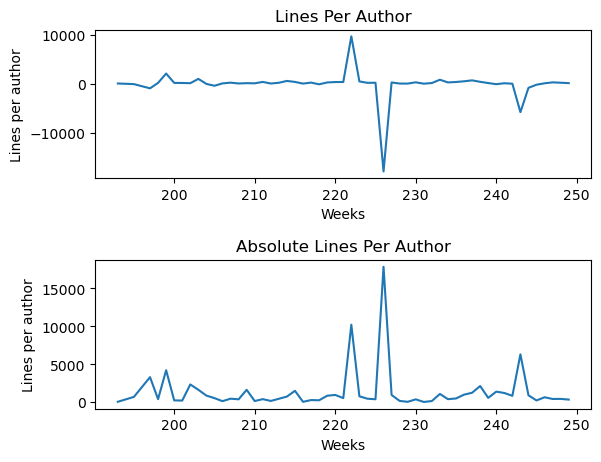

In [153]:
## Creates new DataFrame with column containing average line per author on a weekly basis
plot_df = pd.concat([
    new_df.groupby(["week_num"]).lines.mean().reset_index(),
    new_df.groupby(["week_num"]).abslines.mean().reset_index().drop(["week_num"], axis=1)
], axis=1)
plot_df = plot_df.rename({"lines":"lpa", "abslines":"alpa"}, axis=1)

fig = plt.figure()

fig.subplots_adjust(hspace=0.55, top=0.90)

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.title.set_text("Lines Per Author")
ax1.set_xlabel("Weeks")
ax1.set_ylabel("Lines per author")
ax2.title.set_text("Absolute Lines Per Author")
ax2.set_xlabel("Weeks")
ax2.set_ylabel("Lines per author")

ax1.plot(plot_df["week_num"], plot_df["lpa"])
ax2.plot(plot_df["week_num"], plot_df["alpa"])
